In [567]:
import os
import sys
from pathlib import Path

import cv2
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fontprops = fm.FontProperties(size=34)
import math

import networkx as nx
from PIL import Image
from skimage import measure
from sklearn.metrics.pairwise import paired_distances
from sklearn.neighbors import NearestNeighbors

In [568]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [569]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

In [570]:
import my_io as io
from config import *

In [571]:
datasets = sorted([str(f) for f in data_raw.iterdir() if f.is_dir()])
datasets = [name.split("\\")[-1] for name in datasets]
print(datasets)

['DT1', 'DT2', 'DT3', 'DT4', 'DT5', 'DT6', 'NT1', 'NT2', 'NT3', 'NT4', 'NT5', 'NT6']


In [572]:
dataset = datasets[0]

# Read image 

In [573]:
imgs = []
markers = []
masks = []

for (dirpath, dirnames, filenames) in os.walk(data_raw / dataset):
    for name in sorted(filenames):
        if "tiff" in name and dataset in name:
            img = cv2.imread(
                os.path.join(dirpath, name),
                flags=(cv2.IMREAD_GRAYSCALE | cv2.IMREAD_ANYDEPTH),
            )
            imgs.append(img)
            markers.append(name.split("_")[1].split(".")[0])

for (dirpath, dirnames, filenames) in os.walk(data_mask / dataset):
    for name in sorted(filenames):
        if "tiff" in name and dataset in name:
            img = cv2.imread(os.path.join(dirpath, name), 0)
            masks.append(img)

# Read cell mask image
for (dirpath, dirnames, filenames) in os.walk(data_cell_mask):
    for name in sorted(filenames):
        if "tiff" in name and dataset in name:
            cell_mask = np.array(Image.open(os.path.join(dirpath, name)))

In [574]:
df_cluster = pd.read_csv(data_cluster / (dataset + "_cluster.csv"))
df_cluster.set_index("Marker", inplace=True)

In [575]:
labels = df_cluster.loc[markers]["Cluster"].values.tolist()
n_clusters = len(np.unique(labels))

In [576]:
df_cluster = df_cluster.rename(index={"Histone3": "H3"})
per_cluster = (
    df_cluster.reset_index().groupby(["Cluster"])["Marker"].agg(lambda x: "/".join(x))
)
mapping = per_cluster.to_dict()

# Get Cluster representation and mask

In [577]:
# Generate cluster image representation
img_cluster = {}
for i in range(n_clusters):
    avg_imgs = []
    for k, label in enumerate(labels):
        if label == i:
            avg_imgs.append(imgs[k])
    arr = np.array(np.mean(avg_imgs, axis=(0)), dtype=np.uint8)
    img_cluster[i] = arr

In [578]:
# Extract intensity range of cluster representation
int_max = np.max(np.array(list(img_cluster.values())), axis=(1, 2))
int_range = [[0, 0] for i in range(8)]
for idx, level in enumerate(int_max):
    int_range[idx] = [0, level]

In [579]:
vals = np.linspace(0, 1, n_clusters)
np.random.seed(0)
np.random.shuffle(vals)
my_color = plt.cm.gist_rainbow(vals)

In [580]:
DEFAULT_CHANNELS = [i for i in range(1, n_clusters + 1)]
RGB_MAP = {
    i: {"rgb": my_color[i - 1][:3] * 255, "range": int_range[i - 1]}
    for i in DEFAULT_CHANNELS
}

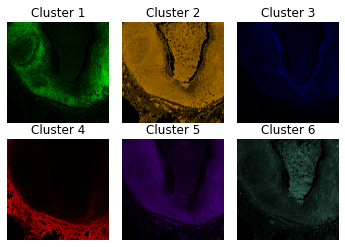

In [581]:
# Show cluster representation in color
imgs_rgb = []
for i in range(n_clusters):
    imgs_rgb.append(io.one_channel(img_cluster[i][:, :, None], i + 1, vmax=int_max[i]))

fig, axs = plt.subplots(2, math.ceil(n_clusters / 2))
axs = axs.flatten()
for idx, img in enumerate(imgs_rgb):
    axs[idx].imshow(img, cmap="gray")
    axs[idx].set_title(f"Cluster {idx+1}")
for ax in axs:
    ax.axis("off")
    ax.set_aspect("equal")

fig.subplots_adjust(wspace=0.1, hspace=0.15)
# fig.savefig(data_figure / 'clusters' / f'{dataset}_cluster_rep.png', bbox_inches='tight')
plt.show()

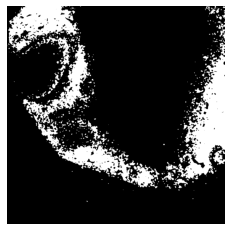

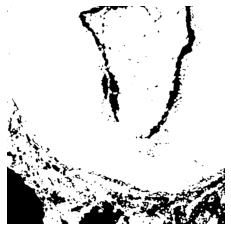

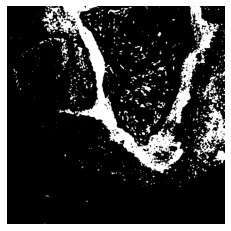

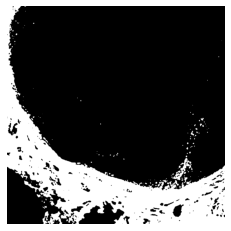

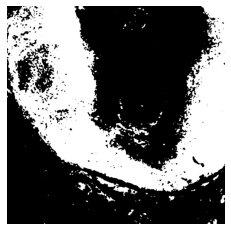

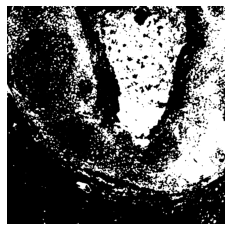

In [582]:
# Stack all cluster representation together
img_cluster = list(img_cluster.values())

mask_cluster = []
for img in img_cluster:
    blur = cv2.GaussianBlur(img, (25, 25), 0)
    ret, th = cv2.threshold(blur, 40, 255, cv2.THRESH_BINARY)
    mask_cluster.append(th)
    plt.imshow(th, cmap="gray")
    plt.axis("off")
    plt.show()

# Inter cluster

In [583]:
n = 10
neigh = NearestNeighbors(n_neighbors=n)

In [584]:
cell_centroid_cluster = {}
cell_count_cluster = {}

for i, mask in enumerate(mask_cluster):
    res = cv2.bitwise_and(cell_mask, cell_mask, mask=mask)
    prop = measure.regionprops_table(res, properties=["centroid", "area"])
    # Read points location
    cell_centroid_cluster[i] = np.vstack((prop["centroid-0"], prop["centroid-1"])).T
    cell_count_cluster[i] = len(prop["centroid-0"])

In [585]:
inter_cluster_nn = {}
for i in range(len(cell_centroid_cluster) - 1):
    inter_cluster_nn[i] = {}
    X = cell_centroid_cluster[i]
    neigh.fit(X)
    for j in range(i + 1, len(cell_centroid_cluster)):
        Y = cell_centroid_cluster[j]
        # fit the NN
        neighbors = neigh.kneighbors(Y, return_distance=False)
        # Get the n neirest neighbors position per cell
        n_distance = X[neighbors]
        # Computes the distances between (X[0], Y[0]), (X[1], Y[1]) ....
        distance = paired_distances(Y, n_distance.mean(axis=1))
        inter_cluster_nn[i][j] = {"weight": 1 / distance.mean()}

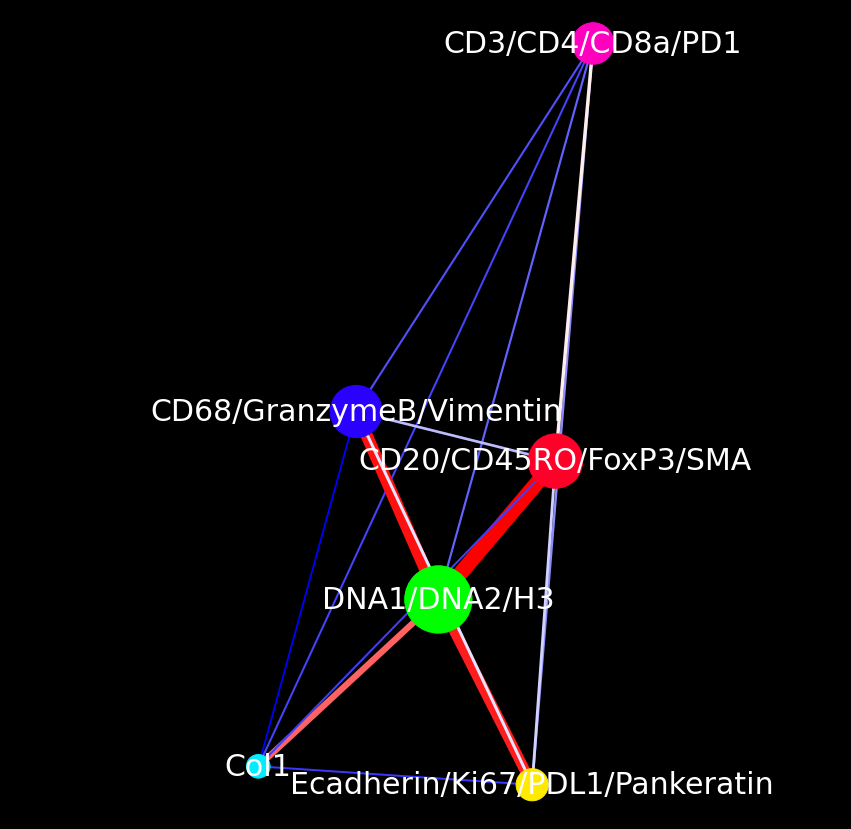

In [586]:
G = nx.from_dict_of_dicts(inter_cluster_nn)
G = nx.relabel_nodes(G, mapping)

edges = G.edges()
weights = np.array([G[u][v]["weight"] for u, v in edges])
edge_c = np.log(weights)
edge_w = 1 / np.log(weights) * 10
size = np.array(list(cell_count_cluster.values()))
size = size / 10
pos = nx.spring_layout(G, seed=1)

fig, ax = plt.subplots(figsize=(15, 15))
nx.draw(
    G,
    pos=pos,
    with_labels=True,
    node_size=size,
    node_color=my_color,
    font_size=30,
    font_color="white",
    width=edge_w,
    edge_color=edge_c,
    edge_cmap=plt.cm.bwr,
)

fig.set_facecolor("black")
x_values, y_values = zip(*pos.values())
x_max = max(x_values)
x_min = min(x_values)
x_margin = (x_max - x_min) * 0.75
plt.xlim(x_min - x_margin, x_max + x_margin)
plt.show()
# fig.savefig(data_figure / 'clusters' / f'{dataset}_cluster_inter.png', bbox_inches='tight')

# Intra cluster

In [587]:
cell_centroid_marker = {}
cell_count_marker = {}

for i, mask in enumerate(masks):
    res = cv2.bitwise_and(cell_mask, cell_mask, mask=mask)
    prop = measure.regionprops_table(res, properties=["centroid", "area"])
    # Read points location
    cell_centroid_marker[i] = np.vstack((prop["centroid-0"], prop["centroid-1"])).T
    cell_count_marker[i] = len(prop["centroid-0"])

In [588]:
intra_cluster_nn = {}
for i in range(len(cell_centroid_marker) - 1):
    intra_cluster_nn[markers[i]] = {}
    X = cell_centroid_marker[i]
    neigh.fit(X)
    label_x = labels[i]
    for j in range(i + 1, len(cell_centroid_marker)):
        label_y = labels[j]
        if label_x != label_y:
            continue

        Y = cell_centroid_marker[j]
        # fit the NN
        neighbors = neigh.kneighbors(Y, return_distance=False)
        # Get the n neirest neighbors position per cell
        n_distance = X[neighbors]
        # Computes the distances between (X[0], Y[0]), (X[1], Y[1]) ....
        distance = paired_distances(Y, n_distance.mean(axis=1))
        intra_cluster_nn[markers[i]][markers[j]] = {"weight": 1 / distance.mean()}
intra_cluster_nn[markers[-1]] = {}

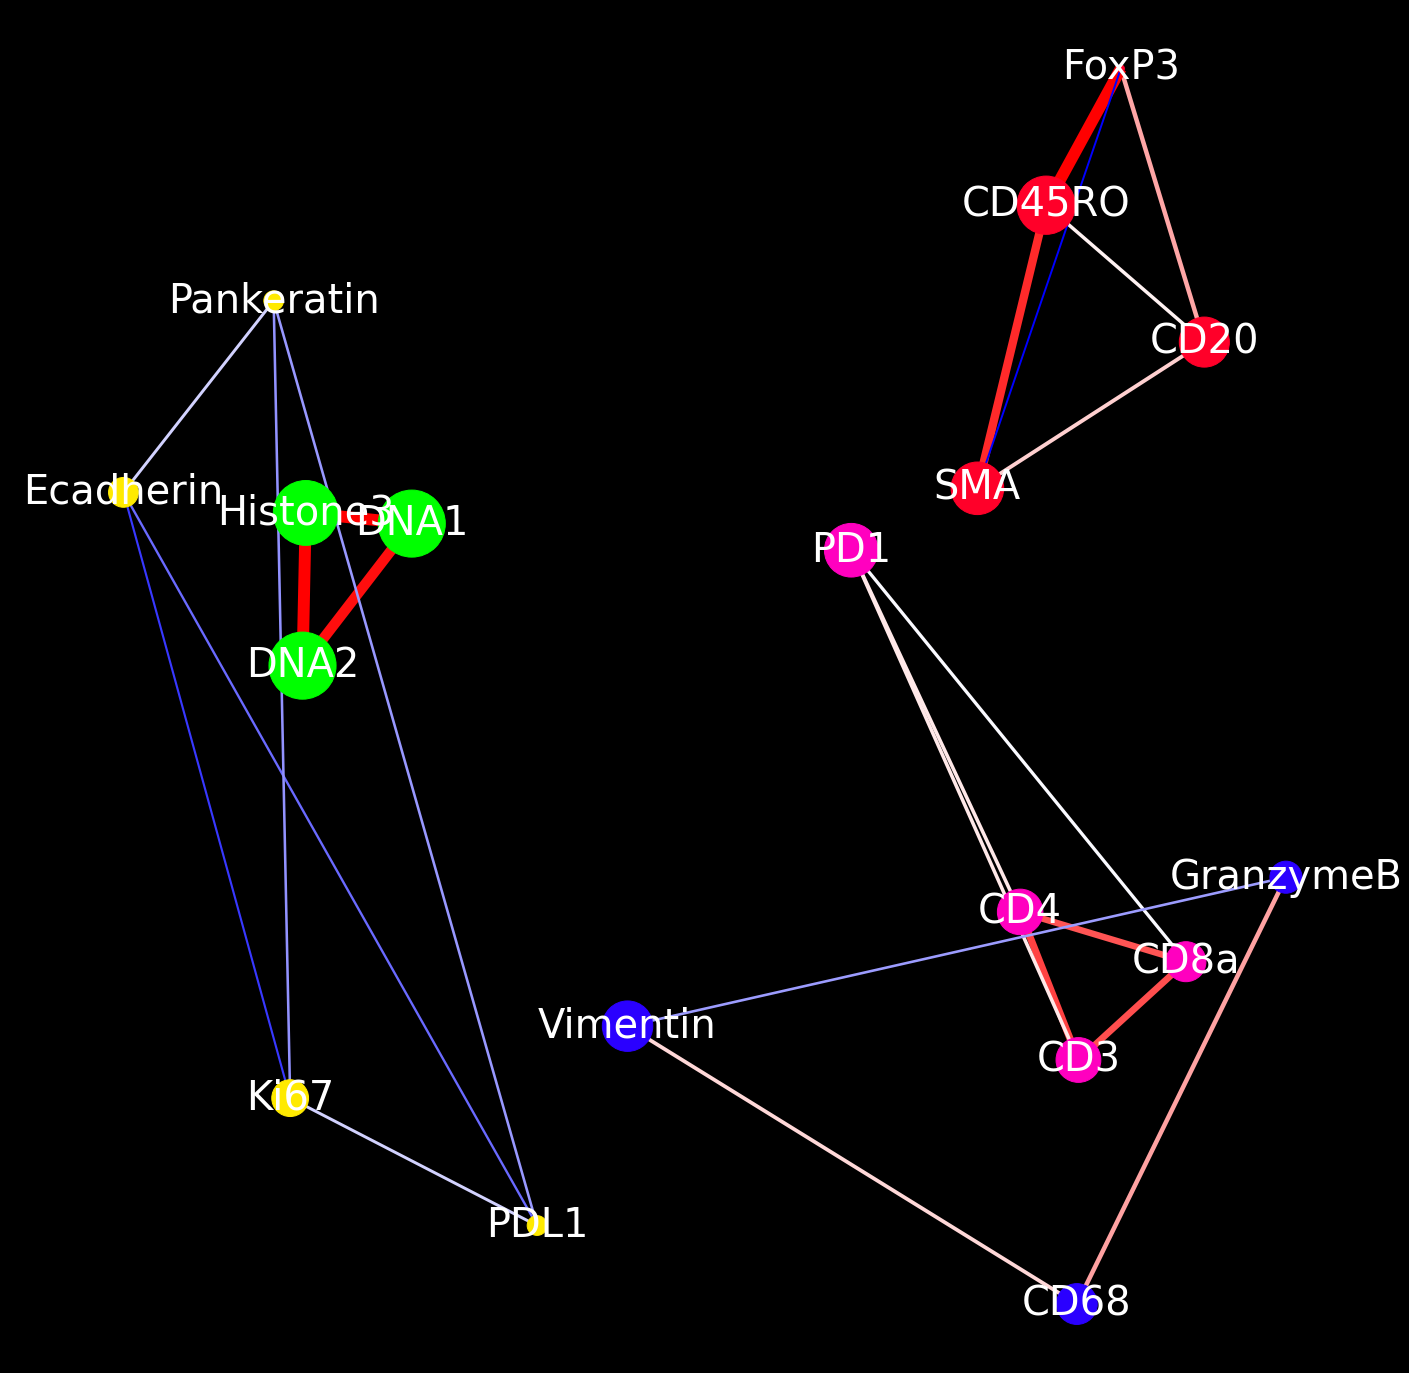

In [593]:
G = nx.from_dict_of_dicts(intra_cluster_nn)
drop_nodes = list(nx.isolates(G))
index_G = [i for i, marker in enumerate(markers) if marker not in drop_nodes]
label_G = [labels[i] for i, marker in enumerate(markers) if marker not in drop_nodes]
G.remove_nodes_from(drop_nodes)

edges = G.edges()
weights = np.array([G[u][v]["weight"] for u, v in edges])
edge_c = np.log(weights)
edge_w = 1 / np.log(weights) * 10
size = np.array(list(cell_count_marker.values()))[index_G]
size = size / 10
pos = nx.spring_layout(G, k=0.3, iterations=30, seed=0)

fig, ax = plt.subplots(figsize=(25, 25))
nx.draw(
    G,
    pos=pos,
    with_labels=True,
    node_size=size,
    node_color=my_color[label_G],
    font_size=40,
    font_color="white",
    width=edge_w,
    edge_color=edge_c,
    edge_cmap=plt.cm.bwr,
)

fig.set_facecolor("black")
x_values, y_values = zip(*pos.values())
x_max = max(x_values)
x_min = min(x_values)
x_margin = (x_max - x_min) * 0.1
plt.xlim(x_min - x_margin, x_max + x_margin)
plt.show()
fig.savefig(
    data_figure / "clusters" / f"{dataset}_cluster_intra.png", bbox_inches="tight"
)